In [ ]:
import os, math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# find data files
all_files_name = os.listdir("./data")
data_files_name = [i for i in all_files_name if "hourly.csv" in i]
# read all files
df_list = [pd.read_csv("./data/"+file_name,index_col='Datetime') for file_name in data_files_name]
print(f"{len(df_list)} files loaded.")

12 files loaded.


In [ ]:
# print summary of the power consumption
sample = [i.describe() for i in df_list]
pd.concat(sample, axis = 1)

,AEP_MW,DAYTON_MW,DEOK_MW,COMED_MW,EKPC_MW,FE_MW,DOM_MW,DUQ_MW,PJMW_MW,NI_MW,PJM_Load_MW,PJME_MW
count,121273.000000,121275.000000,57739.000000,66497.000000,45334.000000,62874.000000,116189.000000,119068.000000,143206.000000,58450.000000,32896.000000,145366.000000
mean,15499.513717,2037.851140,3105.096486,11420.152112,1464.218423,7792.159064,10949.203625,1658.820296,5602.375089,11701.682943,29766.427408,32080.222831
std,2591.399065,393.403153,599.859026,2304.139517,378.868404,1331.268006,2413.946569,301.740640,979.142872,2371.498701,5849.769954,6464.012166
min,9581.000000,982.000000,907.000000,7237.000000,514.000000,0.000000,1253.000000,1014.000000,487.000000,7003.000000,17461.000000,14544.000000
25%,13630.000000,1749.000000,2687.000000,9780.000000,1185.000000,6807.000000,9322.000000,1444.000000,4907.000000,9954.000000,25473.000000,27573.000000
50%,15310.000000,2009.000000,3013.000000,11152.000000,1386.000000,7700.000000,10501.000000,1630.000000,5530.000000,11521.000000,29655.000000,31421.000000
75%,17200.000000,2279.000000,3449.000000,12510.000000,1699.000000,8556.000000,12378.000000,1819.000000,6252.000000,12896.750000,33073.250000,35650.000000
max,25695.000000,3746.000000,5445.000000,23753.000000,3490.000000,14032.000000,21651.000000,3054.000000,9594.000000,23631.000000,54030.000000,62009.000000


In [ ]:
# get PJME consumption
df = df_list[-3]
df['date'] = [i[0:10] for i in df.index]
df_date = df.groupby(['date']).mean()

In [ ]:
# We only want the last 6 years
df_date = df_date[df_date.index >= "2012-01-01"]

df_train, df_test = df_date[df_date.index < "2018-01-01"].values, \
                    df_date[df_date.index >= "2018-01-01"].values
print(f"train shape: {df_train.size} test shape: {df_test.size}")

train shape: 0 test shape: 0


<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

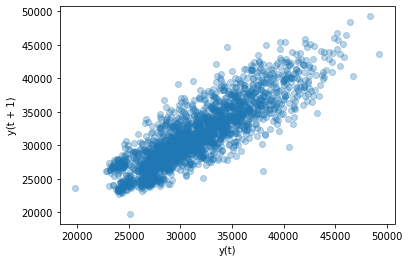

In [ ]:
# autocorrelation check
from pandas.plotting import lag_plot
lag_plot(df_date[df_date.index < "2018-01-01"], alpha=0.3)

Lag: 1 The MAPE for the test set is: 92.81%
Lag: 1 The MSe for the test set is: 895900158.87
Lag: 7 The MAPE for the test set is: 15.51%
Lag: 7 The MSe for the test set is: 41886240.80
Lag: 15 The MAPE for the test set is: 23.60%
Lag: 15 The MSe for the test set is: 73573680.99
Lag: 30 The MAPE for the test set is: 15.70%
Lag: 30 The MSe for the test set is: 40811410.77
Lag: 120 The MAPE for the test set is: 15.22%
Lag: 120 The MSe for the test set is: 40779360.32
Lag: 365 The MAPE for the test set is: 22.00%
Lag: 365 The MSe for the test set is: 80946443.84


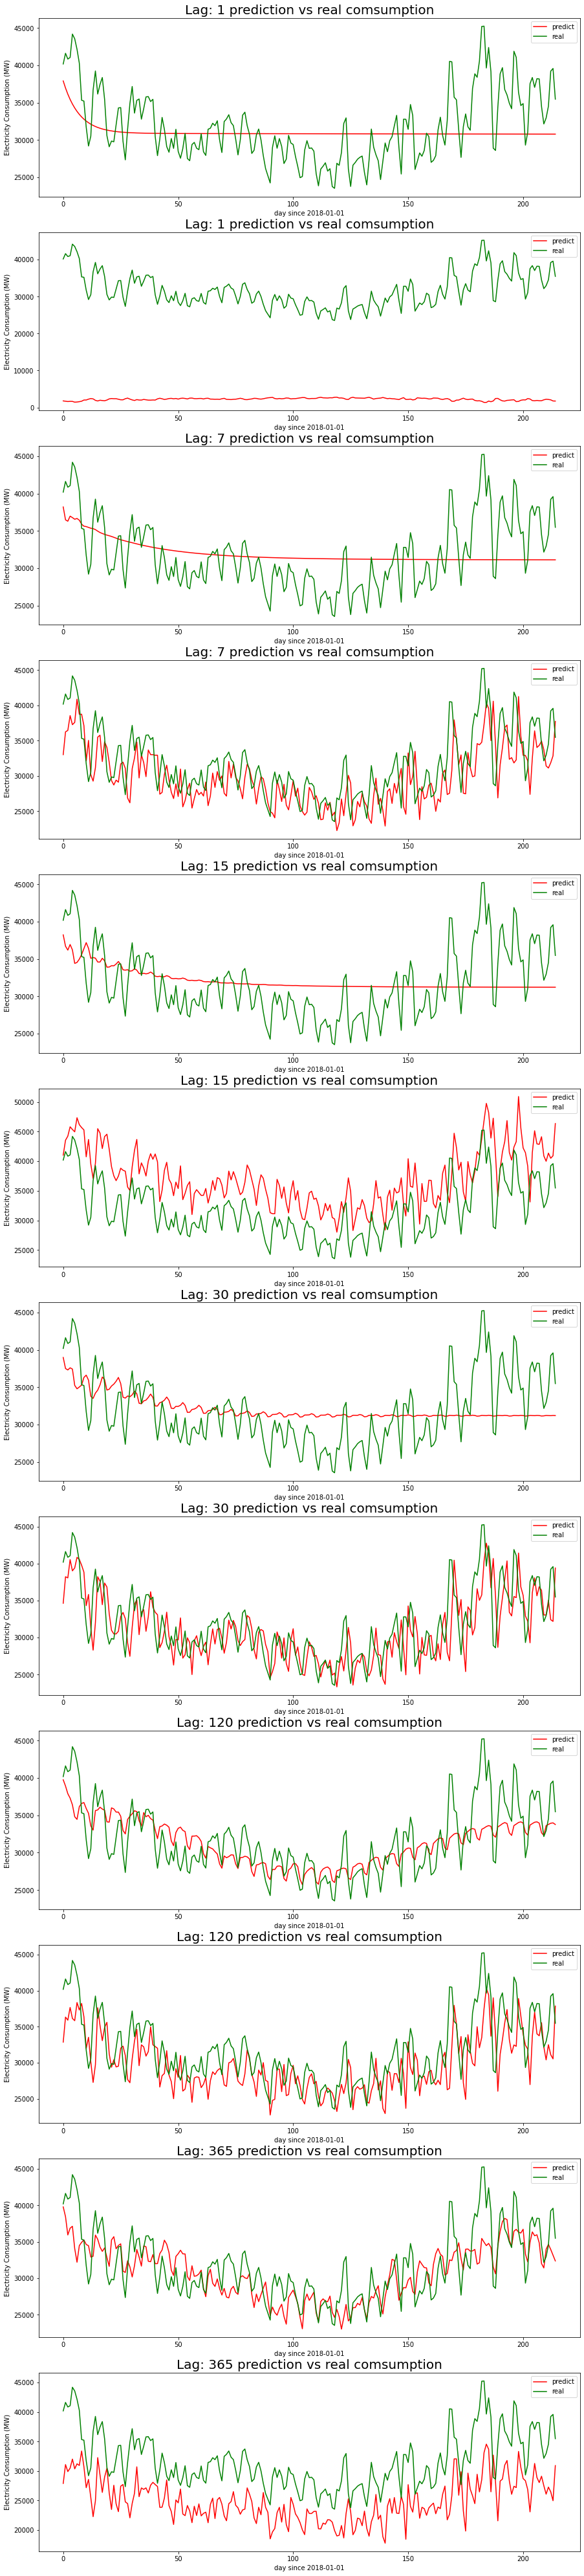

In [ ]:
# training
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
lag_list = [1, 7, 15, 30, 120, 365]
fig, ax = plt.subplots(len(lag_list)*2,1,figsize=(15,len(lag_list)*2*6))

for i, lag in enumerate(lag_list):
    model = AutoReg(df_train, lags=lag, trend='ct', old_names = False)
    model = model.fit()
    # predict on test data
    prediction = model.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, dynamic=False)
    # predict include new value
    prediction2 = np.array([])
    coef = model.params
    history = df_train[len(df_train) - lag:]
    for j, value in enumerate(df_test):
        length = len(history)
        lags = [history[k] for k in range(length - lag, length)]
        yhat = coef[0]
        for d in range(lag):
            yhat += coef[d+1] * lags[lag-d-1]
        history = np.append(history, value)
        prediction2 = np.append(prediction2, yhat)

    # compute the MAPE = mean(abs( (true - predict) / true))
    MAPE = np.mean(np.fabs((df_test - prediction2 ) / df_test))
    print(f"Lag: {lag} The MAPE for the test set is: {MAPE*100:.2f}%")
    MSE = np.mean((prediction2 - df_test)**2)
    print(f"Lag: {lag} The MSe for the test set is: {MSE:.2f}")

    # plot picture on test set.
    for j, values in enumerate([prediction, prediction2]):
        ax[2*i+j].plot(range(len(df_test)), values, 'red')
        ax[2*i+j].plot(range(len(df_test)), df_test, 'green')
        ax[2*i+j].legend(['predict','real'])
        ax[2*i+j].set_title(f'Lag: {lag} prediction vs real comsumption',fontsize=20)
        ax[2*i+j].set_xlabel('day since 2018-01-01')
        ax[2*i+j].set_ylabel('Electricity Consumption (MW)')

The MAPE for the test set is: 22.00%


Text(0, 0.5, 'Electricity Consumption (MW)')

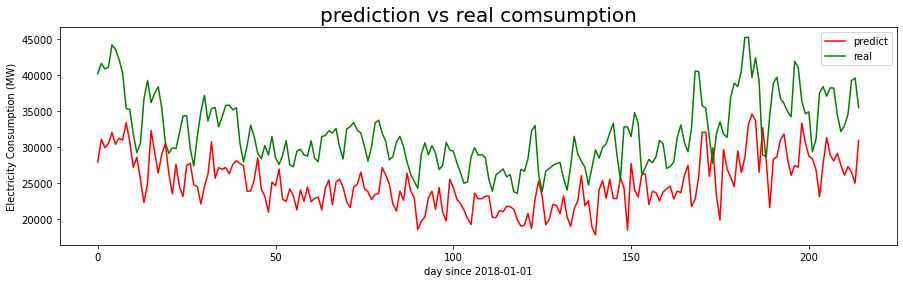

In [ ]:
var = ar_select_order(df_train, 1000, old_names=False)
var.ar_lags
model_2 = var.model.fit()
prediction = model_2.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, dynamic=False)
# predict include new value
prediction2 = np.array([])
coef = model.params
history = df_train[len(df_train) - lag:]
for j, value in enumerate(df_test):
    length = len(history)
    lags = [history[k] for k in range(length - lag, length)]
    yhat = coef[0]
    for d in range(lag):
        yhat += coef[d+1] * lags[lag-d-1]
    history = np.append(history, value)
    prediction2 = np.append(prediction2, yhat)

# compute the MAPE = mean(abs( (true - predict) / true))
MAPE = np.mean(np.fabs((df_test - prediction2 ) / df_test))
print(f"The MAPE for the test set is: {MAPE*100:.2f}%")

# plot picture on test set.
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(range(len(df_test)), prediction2, 'red')
ax.plot(range(len(df_test)), df_test, 'green')
ax.legend(['predict','real'])
ax.set_title('prediction vs real comsumption',fontsize=20)
ax.set_xlabel('day since 2018-01-01')
ax.set_ylabel('Electricity Consumption (MW)')

In [ ]:
# find out the lag system choose.
var.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])